In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [18]:
import pandas as pd

print("📥 Step 1: Importing Dataset")

# Define path and attempt to load
csv_file = "house_price_data.csv"
try:
    housing_df = pd.read_csv(csv_file)
    print(f"✅ Successfully loaded: {csv_file}")
except FileNotFoundError:
    print(f"❌ File not found: {csv_file}")
    exit()

# Step 2: Inspect missing values
print("\n🔍 Missing Value Summary:")
missing_summary = housing_df.isnull().sum()
print(missing_summary)

# Step 3: Impute missing 'Age' if present
if 'Age' in housing_df.columns and housing_df['Age'].isnull().sum() > 0:
    age_median = housing_df['Age'].median()
    housing_df['Age'].fillna(age_median, inplace=True)
    print(f"\n🧹 Filled missing 'Age' values with median: {age_median}")

# Step 4: Display summary statistics
print("\n📊 Descriptive Statistics:")
print(housing_df.describe())

📥 Step 1: Importing Dataset
✅ Successfully loaded: house_price_data.csv

🔍 Missing Value Summary:
property_id                0
neighborhood               0
distance_to_city_center    0
distance_to_metro          0
distance_to_school         0
crime_rate                 0
house_age                  0
total_area                 0
bedrooms                   0
bathrooms                  0
floors                     0
garage                     0
garden                     0
basement                   0
balcony                    0
construction_quality       0
renovation_status          0
heating_type               0
air_conditioning           0
parking_spaces             0
energy_efficiency          0
listing_duration           0
season_sold                0
year_sold                  0
sale_price                 0
dtype: int64

📊 Descriptive Statistics:
       distance_to_city_center  distance_to_metro  distance_to_school  \
count              8000.000000        8000.000000         8000.0

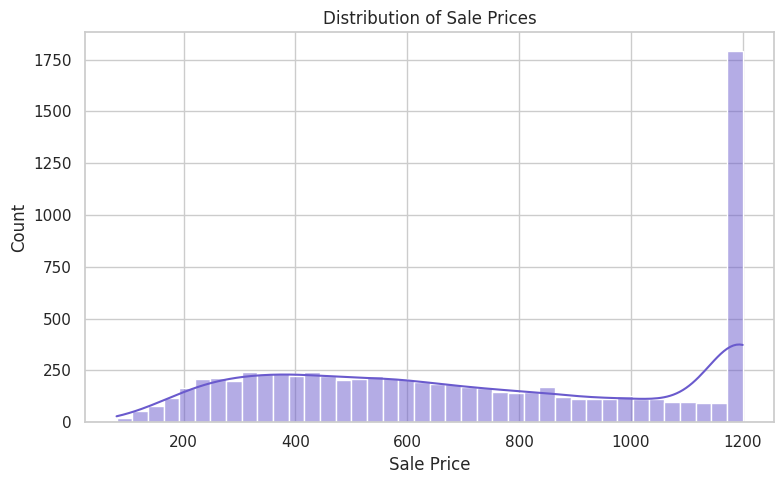

Skewness of Sale Price: 0.07


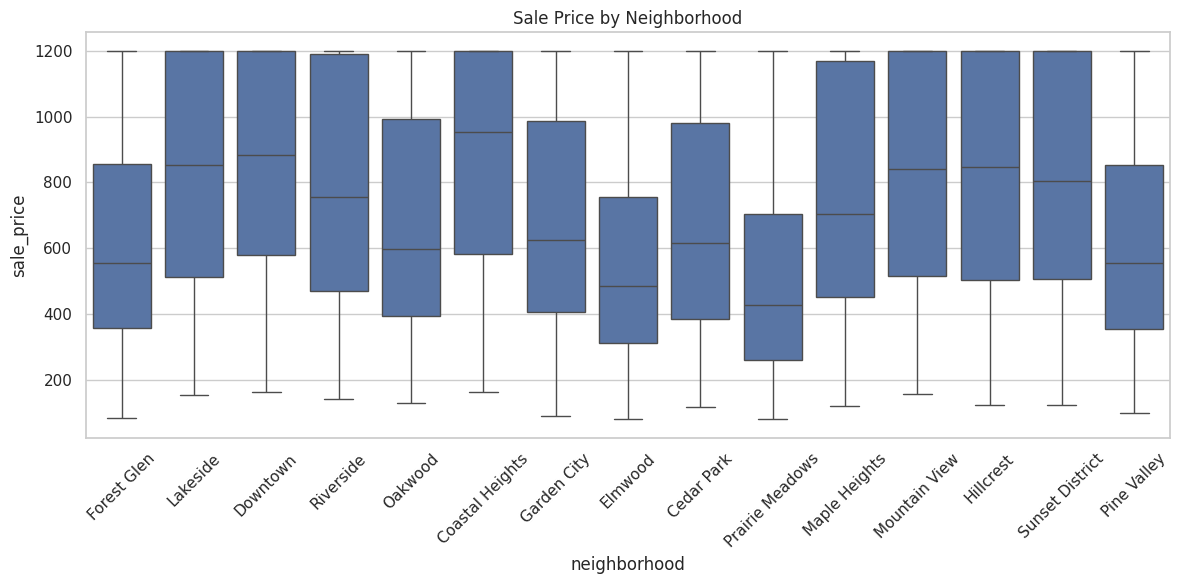

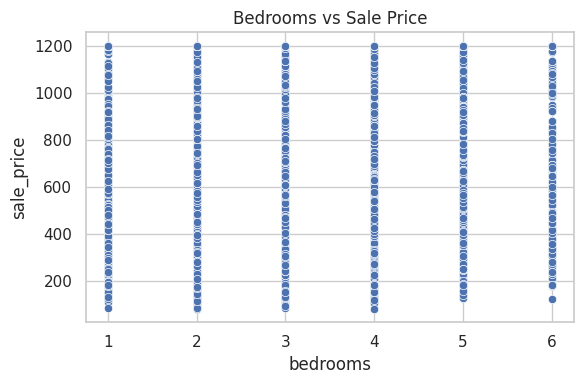

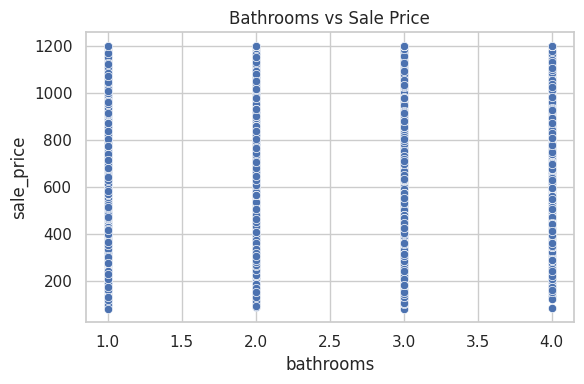

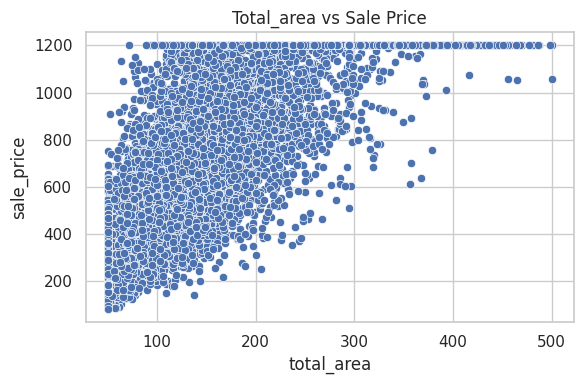

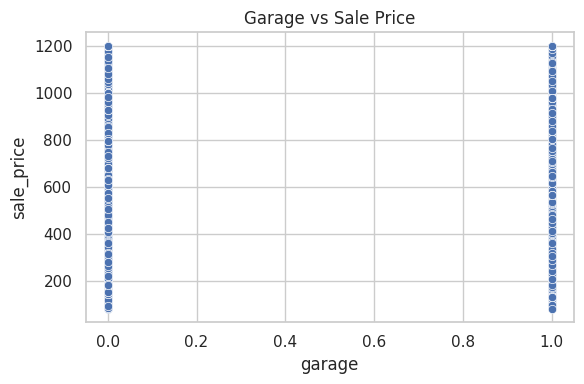

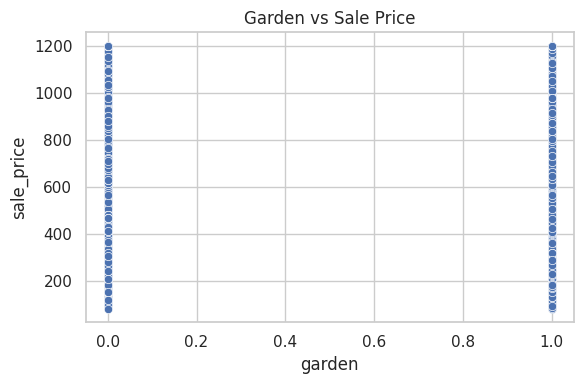

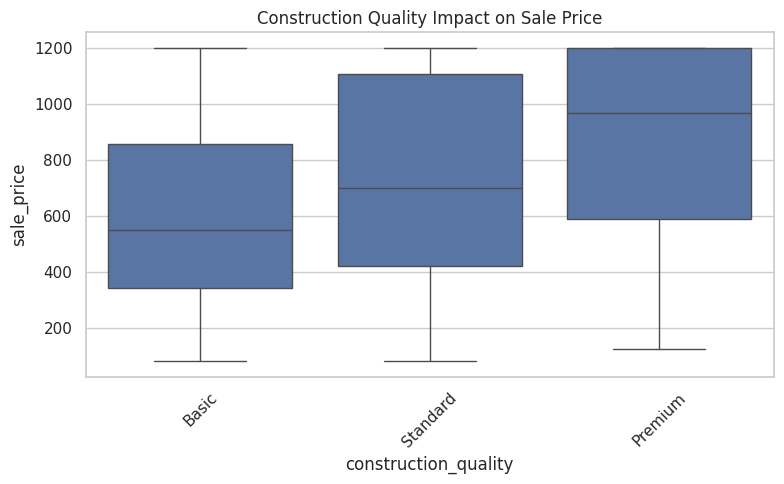

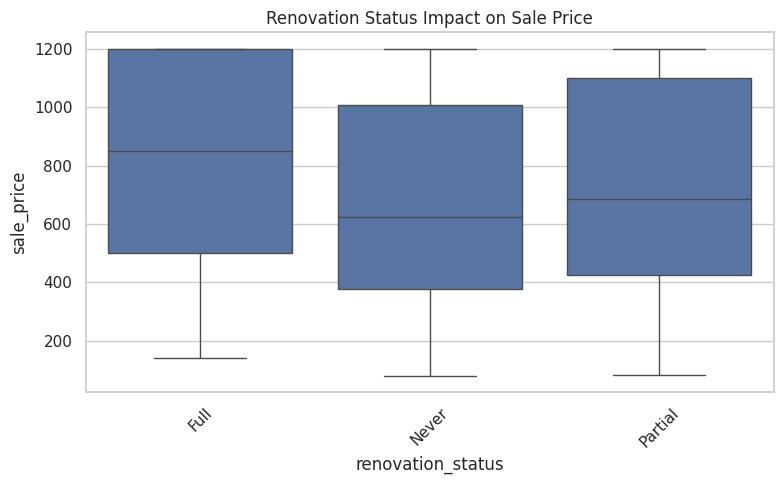

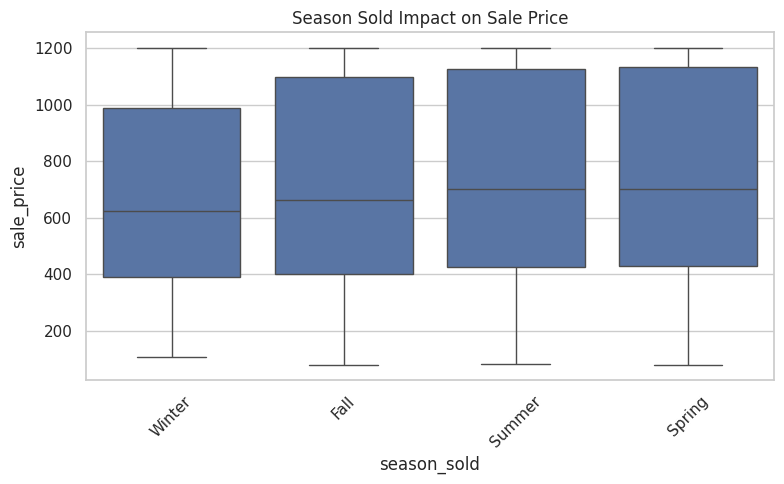

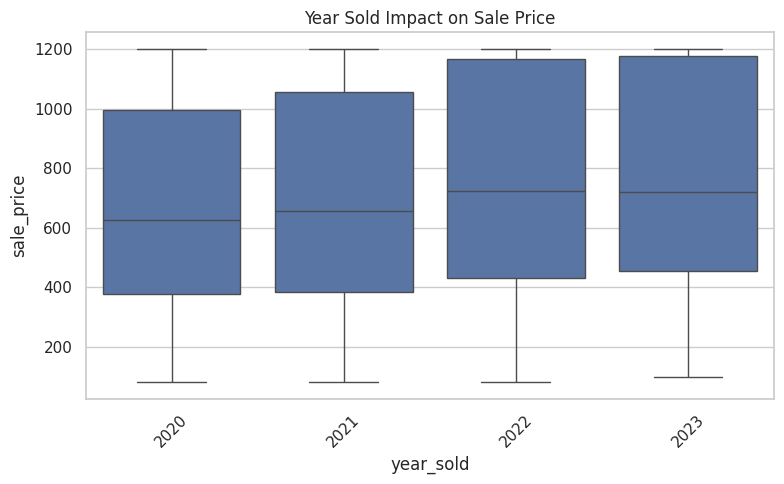

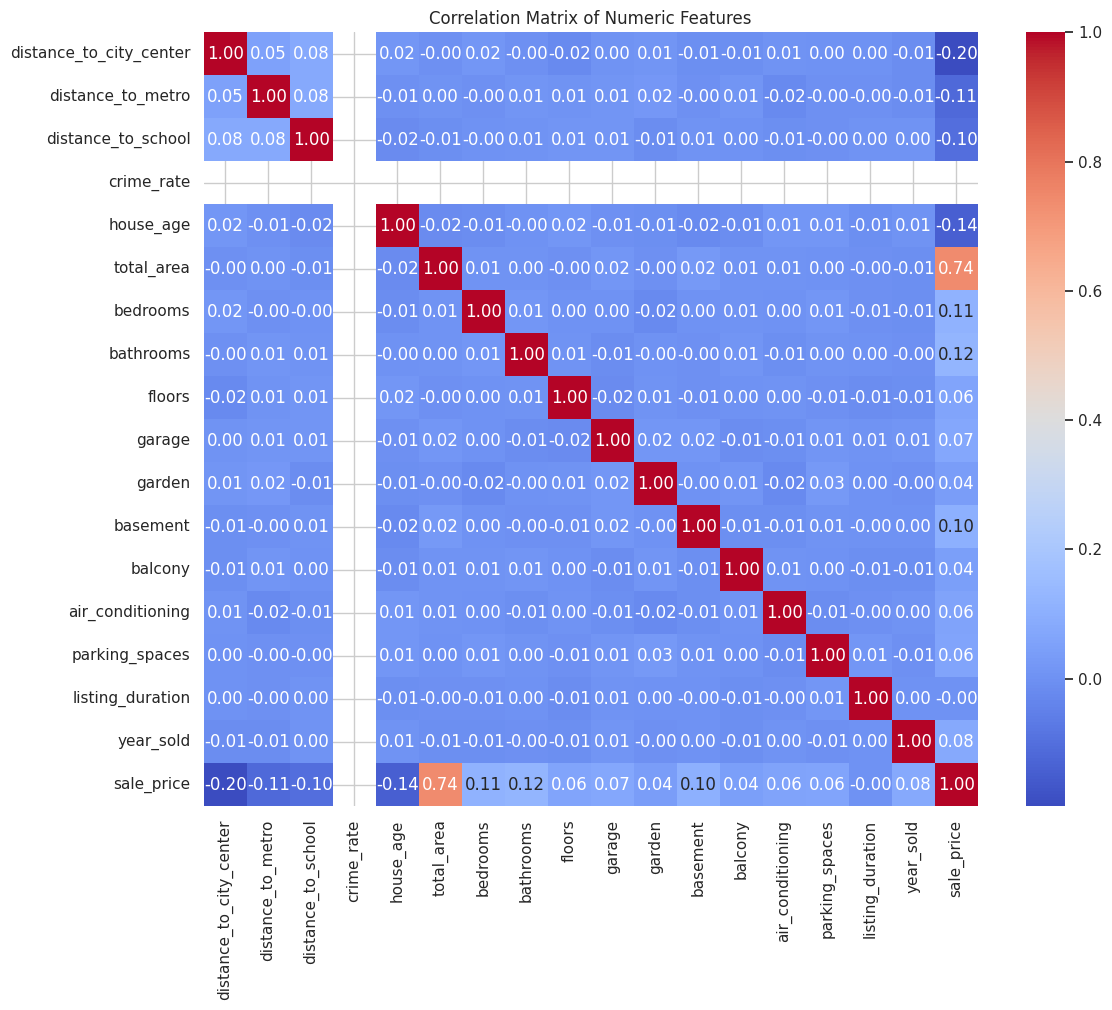


✅ No strong multicollinearity detected.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Set visual style
sns.set(style="whitegrid", palette="deep")

# 1️⃣ Price Distribution & Skewness
plt.figure(figsize=(8, 5))
sns.histplot(housing_df['sale_price'], bins=40, kde=True, color='slateblue')
plt.title("Distribution of Sale Prices")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

price_skew = skew(housing_df['sale_price'].dropna())
print(f"Skewness of Sale Price: {price_skew:.2f}")
if abs(price_skew) > 1:
    print("⚠️ Skewed distribution detected — consider log transformation.")

# 2️⃣ Location & Property Feature Relationships
if 'neighborhood' in housing_df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='neighborhood', y='sale_price', data=housing_df)
    plt.xticks(rotation=45)
    plt.title("Sale Price by Neighborhood")
    plt.tight_layout()
    plt.show()

feature_cols = ['bedrooms', 'bathrooms', 'total_area', 'garage', 'garden']
for feature in feature_cols:
    if feature in housing_df.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=feature, y='sale_price', data=housing_df)
        plt.title(f"{feature.capitalize()} vs Sale Price")
        plt.tight_layout()
        plt.show()

# 3️⃣ Quality Factors & Market Timing
quality_factors = ['construction_quality', 'renovation_status', 'season_sold', 'year_sold']
for factor in quality_factors:
    if factor in housing_df.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=factor, y='sale_price', data=housing_df)
        plt.xticks(rotation=45)
        plt.title(f"{factor.replace('_', ' ').title()} Impact on Sale Price")
        plt.tight_layout()
        plt.show()

# 4️⃣ Correlation Analysis & Multicollinearity
numeric_features = housing_df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

# Detecting multicollinearity
threshold = 0.85
high_corr_pairs = [(i, j, corr_matrix.loc[i, j]) for i in corr_matrix.columns for j in corr_matrix.columns
                   if i != j and abs(corr_matrix.loc[i, j]) > threshold]

if high_corr_pairs:
    print("\n🔁 High Correlation Pairs (Potential Multicollinearity):")
    for i, j, val in high_corr_pairs:
        print(f"{i} & {j} → Correlation: {val:.2f}")
else:
    print("\n✅ No strong multicollinearity detected.")

In [37]:
import pandas as pd
import numpy as np
import torch

print("🔧 Feature Engineering and Preprocessing")

# ⚠️ Reassign dataset explicitly if switching contexts
data = pd.read_csv("house_price_data.csv")  # Update path if needed

# 1️⃣ Standardize column names
data.columns = data.columns.str.strip().str.lower()

# 2️⃣ Confirm target column exists
if 'sale_price' not in data.columns:
    raise ValueError("❌ 'sale_price' column not found. Check column names.")

# 3️⃣ Separate target and features
target = data['sale_price'].copy()
features = data.drop(columns=['sale_price'])

# 4️⃣ Encode categorical variables
categorical_cols = features.select_dtypes(include='object').columns.tolist()
features_encoded = pd.get_dummies(features, columns=categorical_cols, drop_first=True)
print(f"✅ One-hot encoding applied: {len(categorical_cols)} categorical columns transformed.")

# 5️⃣ Reattach target
df_fe = pd.concat([features_encoded, target.reset_index(drop=True)], axis=1)

# 6️⃣ Create derived features
if 'total_area' in df_fe.columns:
    df_fe['price_per_sqft'] = df_fe['sale_price'] / df_fe['total_area']
if 'year_sold' in df_fe.columns and 'house_age' in df_fe.columns:
    df_fe['age_at_sale'] = df_fe['year_sold'] - df_fe['house_age']
print("🆕 New features added: 'price_per_sqft', 'age_at_sale'.")

# 7️⃣ Clip outliers in 'total_area'
if 'total_area' in df_fe.columns:
    cutoff = df_fe['total_area'].quantile(0.99)
    df_fe['total_area'] = df_fe['total_area'].clip(upper=cutoff)
    print(f"📉 Outliers in 'total_area' clipped at 99th percentile: {cutoff:.2f}")

# 8️⃣ Prepare features and target
X_df = df_fe.drop(columns=['sale_price'], errors='ignore')
y_df = df_fe['sale_price']

# 🔄 Convert boolean columns to integers
bool_cols = X_df.select_dtypes(include='bool').columns
X_df[bool_cols] = X_df[bool_cols].astype(int)

# 🔄 Ensure all columns are numeric
X_df = X_df.apply(pd.to_numeric, errors='coerce')
X_df = X_df.fillna(X_df.mean())  # Fill any NaNs

# 9️⃣ Convert to PyTorch tensors
X_tensor = torch.tensor(X_df.values, dtype=torch.float32)
y_tensor = torch.tensor(y_df.values, dtype=torch.float32).view(-1, 1)

# 🔟 Min-max scaling
min_vals = X_tensor.min(dim=0, keepdim=True).values
max_vals = X_tensor.max(dim=0, keepdim=True).values
X_scaled = (X_tensor - min_vals) / (max_vals - min_vals + 1e-8)

# 1️⃣1️⃣ Train-test split
torch.manual_seed(42)
indices = torch.randperm(len(X_scaled))
split_idx = int(0.8 * len(X_scaled))

X_train = X_scaled[indices[:split_idx]]
y_train = y_tensor[indices[:split_idx]]
X_test = X_scaled[indices[split_idx:]]
y_test = y_tensor[indices[split_idx:]]

print(f"\n📦 Train set shape: {X_train.shape}")
print(f"📦 Test set shape: {X_test.shape}")

🔧 Feature Engineering and Preprocessing
✅ One-hot encoding applied: 7 categorical columns transformed.
🆕 New features added: 'price_per_sqft', 'age_at_sale'.
📉 Outliers in 'total_area' clipped at 99th percentile: 416.00

📦 Train set shape: torch.Size([6400, 8047])
📦 Test set shape: torch.Size([1600, 8047])


In [38]:
import torch.nn as nn
import torch.optim as optim

# 1️⃣ Define the Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# 2️⃣ Initialize Model
input_dim = X_train.shape[1]
model = LinearRegressionModel(input_dim)

# 3️⃣ Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 4️⃣ Training Loop
epochs = 500
for epoch in range(epochs):
    model.train()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} → Loss: {loss.item():.4f}")

# 5️⃣ Evaluation
model.eval()
with torch.no_grad():
    test_preds = model(X_test)
    test_loss = criterion(test_preds, y_test)
    print(f"\n📉 Test MSE: {test_loss.item():.4f}")

Epoch 50/500 → Loss: 638581.3125
Epoch 100/500 → Loss: 628837.8125
Epoch 150/500 → Loss: 619229.5000
Epoch 200/500 → Loss: 609754.8125
Epoch 250/500 → Loss: 600411.9375
Epoch 300/500 → Loss: 591199.1875
Epoch 350/500 → Loss: 582114.7500
Epoch 400/500 → Loss: 573157.1250
Epoch 450/500 → Loss: 564324.5000
Epoch 500/500 → Loss: 555615.3125

📉 Test MSE: 565019.9375


📊 Evaluation Metrics:
MAE  : 668.60
MSE  : 565019.94
RMSE : 751.68
R²   : -3.7292


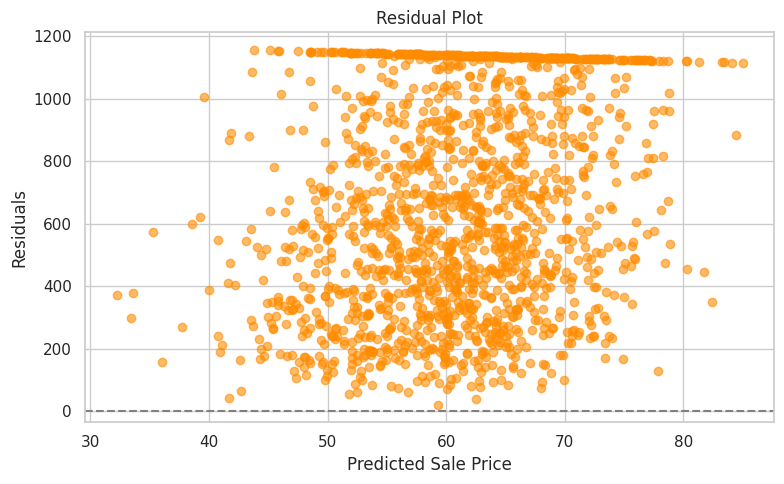


🏆 Best Model: Linear Regression → R² = -3.7292


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Evaluate model on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()
    y_true = y_test.numpy()

# 2️⃣ Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("📊 Evaluation Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")

# 3️⃣ Residual plot
residuals = y_true - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6, color='darkorange')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

# 4️⃣ Model comparison dictionary (expandable)
model_scores = {
    "Linear Regression": {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }
    # Add other models here if needed
}

# 5️⃣ Select best model based on R²
best_model = max(model_scores.items(), key=lambda x: x[1]['R2'])
print(f"\n🏆 Best Model: {best_model[0]} → R² = {best_model[1]['R2']:.4f}")